In [1]:
import random
import math
from matplotlib import pyplot as plt

In [2]:
n = 10
random_walk_end = 6
num_runs = 100
episodes = 800

In [3]:
class RandomWalk:
    def __init__(self, terminal):
        self.terminal = terminal
        self.current = 0

        
    def reset(self):
        self.current = 0

        
    def take_action(self):
        right = random.randint(0, 1)
        if right:
            self.current += 1
        else:
            self.current -= 1
        is_terminal = False
        r = 0
        if abs(self.current) == abs(self.terminal):
            is_terminal = True
            if self.current > 0:
                r = 1
        return is_terminal, self.current, r

In [4]:
class Estimator:
    def __init__(self, random_walk, n, gamma):
        self.terminal = random_walk.terminal
        self.num_states = random_walk.terminal * 2 - 1
        self.V = [0.5 for _ in range(self.num_states)]
        self.n = n
        self.gamma = gamma
    
    def get_V_idx(self, state):
        return state + self.terminal - 1
    
    def getRMSE(self):
        target_values = [i/(self.num_states + 1)
                         for i in range(1, self.num_states + 1)]
        rmse = math.sqrt(
            sum(((x - y)**2 for (x, y) in zip(self.V, target_values)))/self.num_states)
        return rmse

In [5]:
random.seed(2)

In [6]:
class OriginalNStepEstimator(Estimator):
    def __init__(self, n, alpha, random_walk, gamma):
        self.alpha = alpha
        self.random_walk = random_walk
        super().__init__(random_walk, n, gamma)
        
    def learn(self, num_episodes):
        mod = self.n + 1
        rmses = []
        for _ in range(num_episodes):
            self.random_walk.reset()
            R = [0 for _ in range(mod)]
            states = [0 for _ in range(mod)]
            T = float('inf')
            t = 0
            to_update = 0
            while to_update < T - 1:
                if t < T:
                    terminal, state, r = self.random_walk.take_action()
                    idx = (t + 1) % mod
                    R[idx] = r
                    states[idx] = state
                    if terminal:
                        T = t + 1
                to_update = t - self.n + 1
                if to_update > 0:
                    to_update_idx = to_update % mod
                    use_steps_until = min(to_update + self.n, T) + 1
                    G = 0
                    for i in range(to_update + 1, use_steps_until):
                        next_idx = i % mod
                        next_r = R[next_idx]
                        G += self.gamma **(i - to_update - 1) * next_r
                    if to_update + self.n < T:
                        G += self.gamma ** self.n * self.V[self.get_V_idx(state)]
                    state_to_update = self.get_V_idx(states[to_update % mod])
                    self.V[state_to_update] += self.alpha * (G - self.V[state_to_update])
                t += 1
            rmses.append(self.getRMSE())
        return rmses

In [7]:
class TDNStepEstimator(Estimator):
    def __init__(self, n, alpha, random_walk, gamma):
        self.alpha = alpha
        self.random_walk = random_walk
        super().__init__(random_walk, n, gamma)
        
    def learn(self, num_episodes):
        mod = self.n + 1
        rmses = []
        for _ in range(num_episodes):
            self.random_walk.reset()
            TD = [0 for _ in range(mod)]
            states = [0 for _ in range(mod)]
            T = float('inf')
            t = 0
            to_update = 0
            while to_update < T - 1:
                if t < T:
                    terminal, state, r = self.random_walk.take_action()
                    idx = t % mod
                    if terminal:
                        T = t + 1
                        TD[idx] = r - self.V[self.get_V_idx(states[idx])] 
                    else:
                        TD[idx] = r + self.gamma * self.V[self.get_V_idx(state)] - self.V[self.get_V_idx(states[idx])] 
                    next_idx = (t + 1) % mod
                    states[next_idx] = state
                        
                to_update = t - self.n + 1
                if to_update >= 0:
                    to_update_idx = to_update % mod
                    use_steps_until = min(to_update + self.n, T + 1)
                    error = 0
                    for i in range(to_update, use_steps_until):
                        next_idx = i % mod
                        next_td = TD[next_idx]
                        error += self.gamma **(i - to_update) * next_td
                    state_to_update = self.get_V_idx(states[to_update % mod])
                    self.V[state_to_update] += self.alpha * error
                t += 1
            rmses.append(self.getRMSE())
        return rmses

In [8]:
def learn(cls, alpha):
    sum_rmses = [0 for _ in range(episodes)]
    for _ in range(num_runs):
        est = cls(n, alpha, RandomWalk(random_walk_end), 1)
        rmses = est.learn(episodes)
        sum_rmses = map(sum, zip(sum_rmses, rmses))
    return [rmse/num_runs for rmse in sum_rmses]

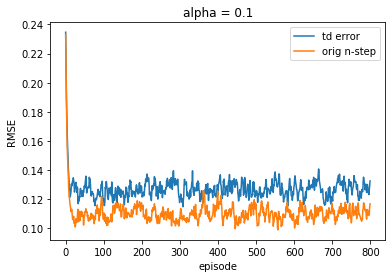

In [9]:
a = 0.1
orig_rmses = learn(OriginalNStepEstimator, a)
td_rmses = learn(TDNStepEstimator, a)
plt.plot(td_rmses)
plt.plot(orig_rmses)
plt.xlabel('episode')
plt.ylabel('RMSE')
plt.title(f'alpha = {a}')
plt.legend(['td error', 'orig n-step'], loc='upper right')
plt.savefig(f'{a}.png')

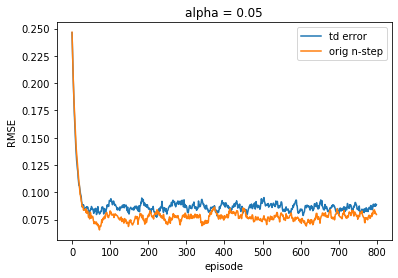

In [10]:
a = 0.05
orig_rmses = learn(OriginalNStepEstimator, a)
td_rmses = learn(TDNStepEstimator, a)
plt.plot(td_rmses)
plt.plot(orig_rmses)
plt.xlabel('episode')
plt.ylabel('RMSE')
plt.title(f'alpha = {a}')
plt.legend(['td error', 'orig n-step'], loc='upper right')
plt.savefig(f'{a}.png')

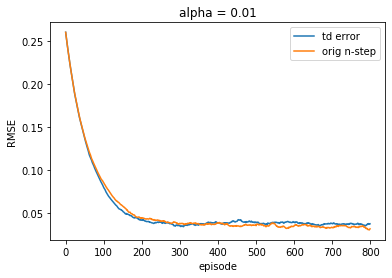

In [11]:
a = 0.01
orig_rmses = learn(OriginalNStepEstimator, a)
td_rmses = learn(TDNStepEstimator, a)
plt.plot(td_rmses)
plt.plot(orig_rmses)
plt.xlabel('episode')
plt.ylabel('RMSE')
plt.title(f'alpha = {a}')
plt.legend(['td error', 'orig n-step'], loc='upper right')
plt.savefig(f'{a}.png')

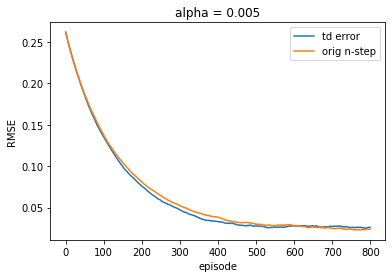

In [12]:
a = 0.005
orig_rmses = learn(OriginalNStepEstimator, a)
td_rmses = learn(TDNStepEstimator, a)
plt.plot(td_rmses)
plt.plot(orig_rmses)
plt.xlabel('episode')
plt.ylabel('RMSE')
plt.title(f'alpha = {a}')
plt.legend(['td error', 'orig n-step'], loc='upper right')
plt.savefig(f'{a}.png')